# Unified Image Quality Benchmark Analysis

**Models Tested**: Siamese E2E, AVA ResNet, Rule-Based IQA  
**Test Set**: 50 images × 27 degradations = 1,350 tests  
**Degradations**: Blur, JPEG, exposure, 4 crop types

In [6]:
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Setup complete!")

Setup complete!


## 1. Load Training History

In [7]:
checkpoint_dir = Path(r'D:\sim-bench\outputs\siamese_e2e\20260111_005327')
with open(checkpoint_dir / 'training_history.json') as f:
    history = json.load(f)

checkpoint = torch.load(checkpoint_dir / 'best_model.pt', map_location='cpu')
print(f"Model trained for {checkpoint['epoch']} epochs")
print(f"Best validation accuracy: {checkpoint['val_acc']:.1%}")

Model trained for 2 epochs
Best validation accuracy: 69.6%


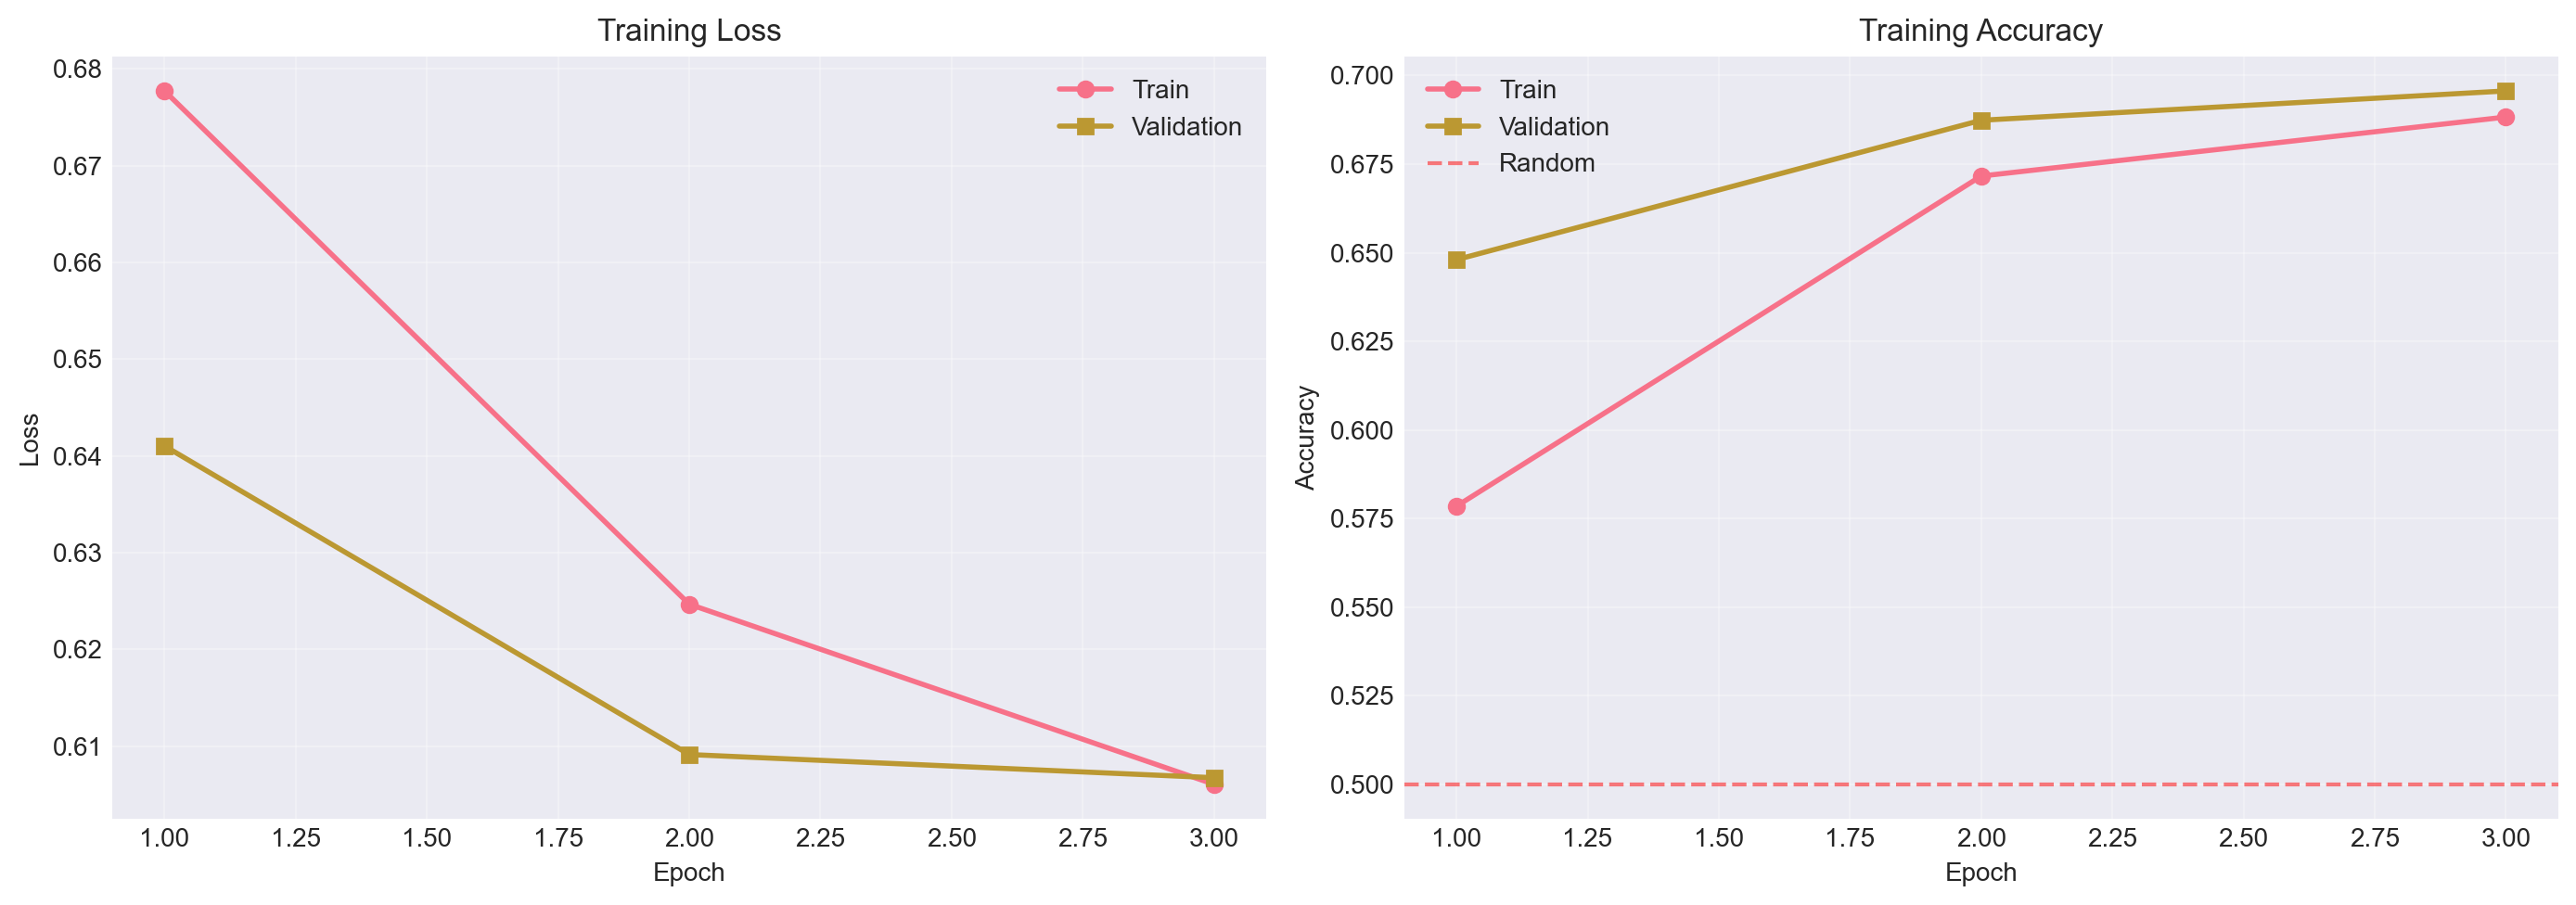

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'o-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 's-', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'o-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 's-', label='Validation', linewidth=2)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Load Benchmark Results

In [ ]:
results_dir = Path(r'D:\sim-bench\outputs\benchmark_ava_vs_siamese')
unified_df = pd.read_csv(results_dir / 'unified_results.csv')
with open(results_dir / 'summary.json') as f:
    summary = json.load(f)

print(f"Loaded {len(unified_df)} predictions")
print(f"Models: {unified_df['model_name'].unique().tolist()}")
print(f"Degradations: {unified_df['degradation_type'].unique().tolist()}")

Loaded 4050 predictions
Models: ['Siamese-E2E', 'AVA-ResNet', 'Rule-Based-IQA']
Degradations: ['blur', 'jpeg', 'exposure', 'crop_edge', 'crop_corner', 'crop_aspect', 'crop_center']


## 3. Overall Comparison

In [10]:
for model_name in unified_df['model_name'].unique():
    model_data = unified_df[unified_df['model_name'] == model_name]
    accuracy = model_data['correct'].mean()
    confidence = model_data['confidence'].mean()
    print(f"{model_name:20s}: {accuracy:6.1%} (confidence: {confidence:.3f})")

Siamese-E2E         :  89.9% (confidence: 0.649)
AVA-ResNet          :  81.9% (confidence: 0.074)
Rule-Based-IQA      :  68.4% (confidence: 0.138)


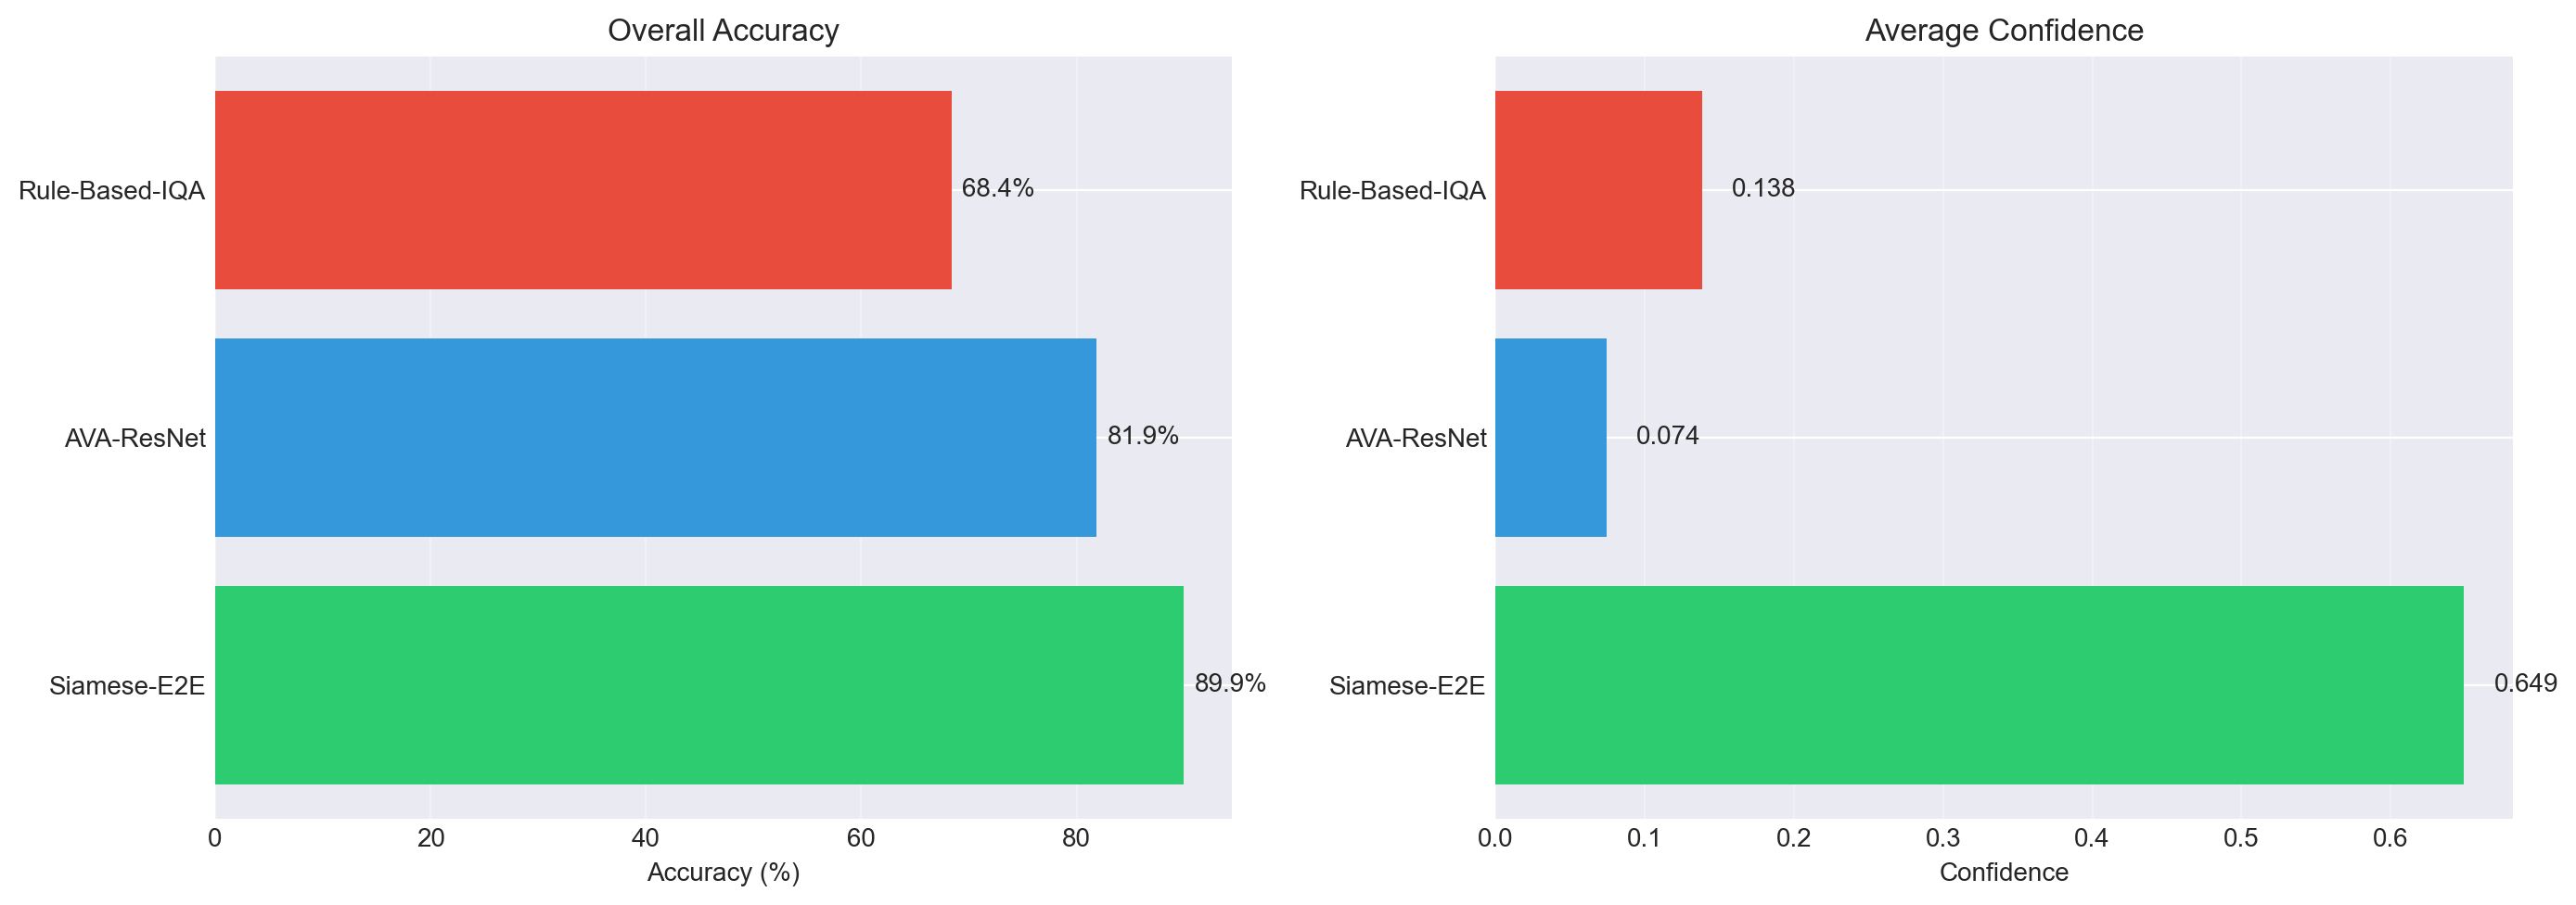

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

models = list(summary['overall'].keys())
accuracies = [summary['overall'][m]['accuracy'] * 100 for m in models]
confidences = [summary['overall'][m]['avg_confidence'] for m in models]

ax1.barh(models, accuracies, color=['#2ecc71', '#3498db', '#e74c3c'])
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Overall Accuracy')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracies):
    ax1.text(v + 1, i, f'{v:.1f}%', va='center')

ax2.barh(models, confidences, color=['#2ecc71', '#3498db', '#e74c3c'])
ax2.set_xlabel('Confidence')
ax2.set_title('Average Confidence')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(confidences):
    ax2.text(v + 0.02, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

## 4. Performance by Degradation

In [12]:
degradation_types = sorted(unified_df['degradation_type'].unique())
model_names = unified_df['model_name'].unique()

accuracy_matrix = []
for deg_type in degradation_types:
    row = []
    for model_name in model_names:
        subset = unified_df[(unified_df['degradation_type'] == deg_type) & 
                           (unified_df['model_name'] == model_name)]
        accuracy = subset['correct'].mean() * 100
        row.append(accuracy)
    accuracy_matrix.append(row)

acc_df = pd.DataFrame(accuracy_matrix, index=degradation_types, columns=model_names)
print(acc_df.round(1))

             Siamese-E2E  AVA-ResNet  Rule-Based-IQA
blur                84.5        92.5           100.0
crop_aspect         94.5        73.0            45.0
crop_center         94.0        68.0            38.0
crop_corner         85.5        76.0            51.5
crop_edge           96.5        67.0            55.5
exposure            74.0        91.0            78.5
jpeg               100.0        95.2            89.6


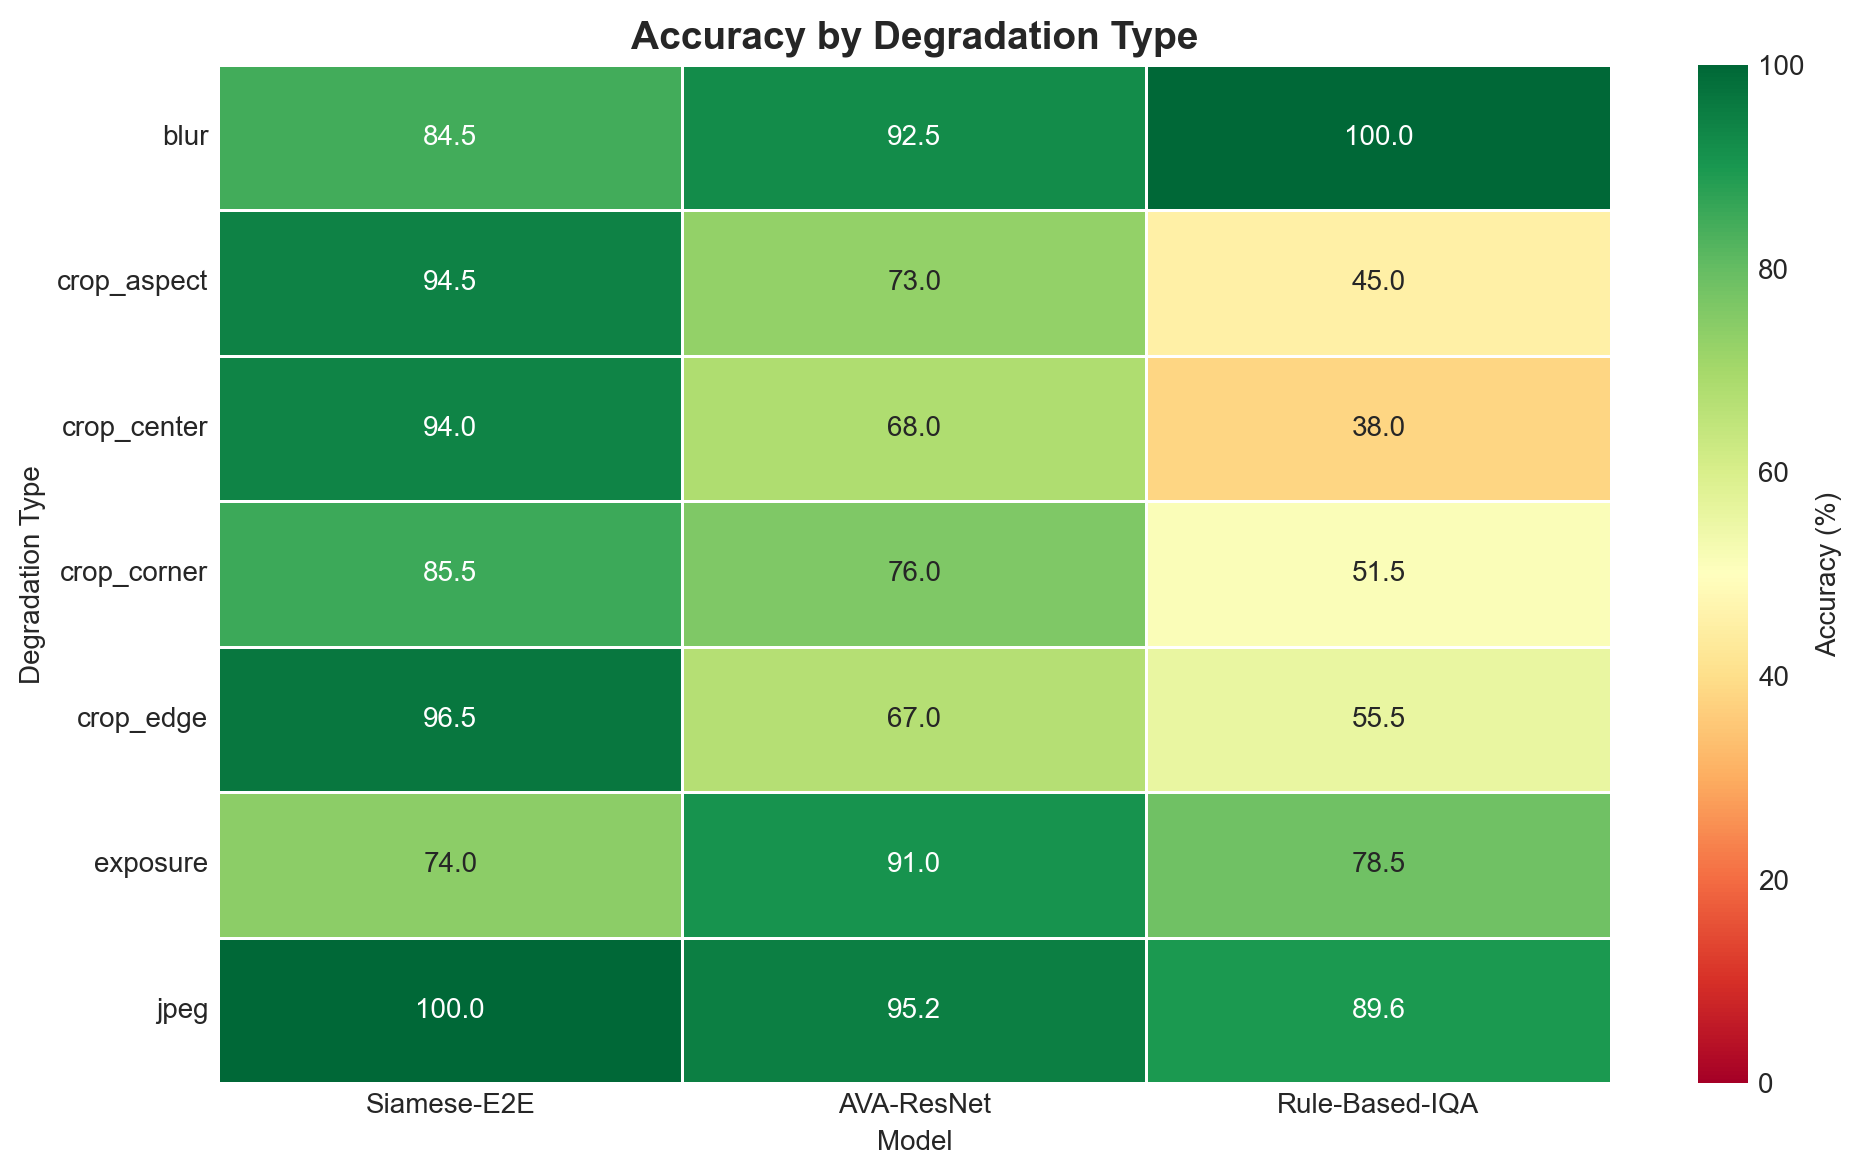

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(acc_df, annot=True, fmt='.1f', cmap='RdYlGn', vmin=0, vmax=100,
            cbar_kws={'label': 'Accuracy (%)'}, linewidths=0.5)
plt.title('Accuracy by Degradation Type', fontsize=14, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Degradation Type')
plt.tight_layout()
plt.show()

## 5. Key Insights

In [14]:
print("="*70)
print("KEY INSIGHTS")
print("="*70)

best_model = max(summary['overall'].items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest Overall: {best_model[0]} ({best_model[1]['accuracy']:.1%})")

print("\nBest by Degradation:")
for deg_type in summary['by_degradation'].keys():
    best = max(summary['by_degradation'][deg_type].items(), key=lambda x: x[1])
    print(f"  {deg_type:15s}: {best[0]:20s} ({best[1]:.1%})")

print("\nModel Specializations:")
print("  Siamese: Compositional quality (crops, framing)")
print("  AVA:     Technical quality (blur, exposure)")
print("  IQA:     Direct metrics (perfect blur detection)")

print("\nRecommendation: Use models together in pipeline!")
print("="*70)

KEY INSIGHTS

Best Overall: Siamese-E2E (89.9%)

Best by Degradation:
  blur           : Rule-Based-IQA       (100.0%)
  jpeg           : Siamese-E2E          (100.0%)
  exposure       : AVA-ResNet           (91.0%)
  crop_edge      : Siamese-E2E          (96.5%)
  crop_corner    : Siamese-E2E          (85.5%)
  crop_aspect    : Siamese-E2E          (94.5%)
  crop_center    : Siamese-E2E          (94.0%)

Model Specializations:
  Siamese: Compositional quality (crops, framing)
  AVA:     Technical quality (blur, exposure)
  IQA:     Direct metrics (perfect blur detection)

Recommendation: Use models together in pipeline!
